In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time

In [2]:
class MLP(nn.Module):
    def __init__(self,architecture=[1,100,1],activation='sigmoid'):
        super(MLP, self).__init__()      
        self.architecture=architecture
        if activation=='sigmoid':
            self.activation=nn.Sigmoid()
        elif activation=='relu':
            self.activation=nn.ReLU()
        else:
            print('Activation not recognized! Using LeakyReLU instead.')
            self.activation=nn.LeakyReLU()
        arch=[]
        for i in range(1,len(architecture)-1):
            arch.append(nn.Linear(architecture[i-1],architecture[i]))            
            arch.append(self.activation)
        self.basis=nn.Sequential(*arch)
        self.regressor=nn.Linear(architecture[-2],architecture[-1])

    def forward(self,f):            
        assert f.shape[1]==self.architecture[0]
        z=self.basis(f)
        out=self.regressor(z)
        return out

In [3]:
#convert the data into a format i like
filename = "../Creating_Action_Units/ActionUnitExtraction.csv"
with open(filename) as file:
    thing = file.read()

lines = [line for line in thing.split("\n") if len(line) > 0]
header = [item for item in lines[0].split(",") if len(item) > 0]
lines = lines[1:]

D = []
for line in lines:
    items = [item for item in line.split(",") if len(item) > 0]
    d = {}
    for i in range(len(header)):
        h = header[i]
        if i < 38:
            d[h] = float(items[i])
        else:
            d[h] = items[i]
    D.append(d)

In [4]:
#some parameters
all_emotions = False
noise = False

#['neutral', 'contempt', 'anger', 'sadness', 'disgust ', 'disgust', 'happiness', 'surprise', 'fear']
good = ["happiness", "surprise"]
neutral = ["neutral"]
bad = ["contempt", "anger", "sadness", "disgust", "fear"]
for d in D:
    emotion = d['labels_AMY'].strip()
    d['labels_AMY'] = emotion
    if not all_emotions:
        if emotion in good:
            d['labels_AMY'] = "good"
        elif emotion in neutral:
            d['labels_AMY'] = "neutral"
        elif emotion in bad:
            d['labels_AMY'] = "bad"

In [5]:
device = "cuda"
#get specs
N = len(D)
AU_keys = [key for key in D[0].keys() if "AU" in key]
AU_N = len(AU_keys)
emotions = list(set([d['labels_AMY'] for d in D]))
emotion_N = len(emotions)
emotion_dict = {}
for i in range(emotion_N):
    emotion_dict[emotions[i]] = i

train_N = int(N*.7)
test_N = (N - train_N)//2
valid_N = N - test_N - train_N

idx = torch.randperm(N)
train_idx = idx[0:train_N]
test_idx = idx[train_N:-valid_N]
valid_idx = idx[train_N + valid_N:]

#format data
data = torch.zeros((N, AU_N)).type(torch.float32).to(device) #200 by 35
label = torch.zeros((N, 1)).type(torch.long).to(device) #200 by 1
for i in range(N):
    for j in range(AU_N):
        data[i, j] = D[i][AU_keys[j]]
    label[i, 0] = emotion_dict[D[i]["labels_AMY"]]

#split into sets
train_data = data[train_idx, :]
test_data = data[test_idx, :]
valid_data = data[valid_idx, :]
train_label = label[train_idx, 0]
test_label = label[test_idx, 0]
valid_label = label[valid_idx, 0]

print("Size training set:", train_label.cpu().numpy().shape[0])
print("Size testing set:", test_label.cpu().numpy().shape[0])
print("Size valid set:", valid_label.cpu().numpy().shape[0])

Size training set: 140
Size testing set: 30
Size valid set: 30


In [6]:
#see how many of each emotion there are in each dataset
n_dict = {}
size_dict = {}
for key in ["all","train","valid","test"]:
    n_dict[key] = {}
    size_dict[key] = 0

for i in range(len(emotions)):
    train_n = train_label.cpu().numpy().tolist().count(i)
    valid_n = valid_label.cpu().numpy().tolist().count(i)
    test_n = test_label.cpu().numpy().tolist().count(i)
    n_dict["train"][emotions[i]] = train_n
    n_dict["valid"][emotions[i]] = valid_n
    n_dict["test"][emotions[i]] = test_n
    n_dict["all"][emotions[i]] = train_n + valid_n + test_n
    size_dict["train"] += train_n
    size_dict["valid"] += valid_n
    size_dict["test"] += test_n
    size_dict["all"] += train_n + valid_n + test_n

for key in ["all","train","valid","test"]:
    print(key)
    size = size_dict[key]
    for emotion in emotions:
        n = n_dict[key][emotion]
        print("\t",emotion,":", n, ":", round(100*n/size, 2), "%")

all
	 bad : 93 : 46.5 %
	 good : 45 : 22.5 %
	 neutral : 62 : 31.0 %
train
	 bad : 66 : 47.14 %
	 good : 31 : 22.14 %
	 neutral : 43 : 30.71 %
valid
	 bad : 13 : 43.33 %
	 good : 8 : 26.67 %
	 neutral : 9 : 30.0 %
test
	 bad : 14 : 46.67 %
	 good : 6 : 20.0 %
	 neutral : 10 : 33.33 %


In [7]:
objective = torch.nn.CrossEntropyLoss()
n_epochs = 10000
lr = 0.005
batch_size = 20
batch_num = train_N//batch_size
arch = [AU_N, 100, 50, emotion_N]
#arch = [AU_N, 100, emotion_N]
model = MLP(arch)
model.to(device)
optim=torch.optim.Adam(model.parameters(),lr=lr)

In [8]:
def transform(batch_data):
    if noise:
        batch_data = batch_data + torch.randn(batch_data.shape).to(device)*.2
    return batch_data

def accuracy(pred, label):
    pred = pred.cpu().detach().numpy()
    label = label.cpu().detach().numpy()
    pred_label = np.argmax(pred, axis = 1)
    return (label == pred_label).mean()

In [9]:
train_losses = []
valid_losses = []

start_time = time.time()
for n in range(n_epochs):
    #make batch
    batch_idx = torch.randperm(train_N)[0:batch_size]
    batch_data = train_data[batch_idx, :]
    batch_data = transform(batch_data)
    batch_label = train_label[batch_idx]
    #make prediction
    batch_pred = model(batch_data)
    #get loss
    train_loss = objective(batch_pred, batch_label)
    train_losses.append(train_loss.item())
    #optimizer step
    optim.zero_grad()
    train_loss.backward()
    optim.step()
    #do valid losses
    with torch.no_grad():
        valid_pred = model(valid_data)
        valid_loss = objective(valid_pred, valid_label)
        valid_losses.append(valid_loss.item())
end_time = time.time()
print(end_time - start_time, "seconds")

19.556997776031494 seconds


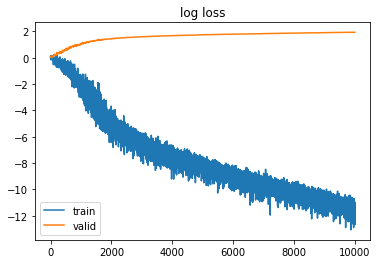

Architecture: [35, 100, 50, 3]
Num emotions: 3
train accuracy: 1.0
valid accuracy: 0.5666666666666667
test accuracy: 0.4666666666666667
Num epochs: 10000
Batch size: 20
Noise added: False


In [10]:
plt.plot(np.log(train_losses))
plt.plot(np.log(valid_losses))
plt.title("log loss")
plt.legend(["train", "valid"])
plt.show()

with torch.no_grad():
    train_pred = model(train_data)
    test_pred = model(test_data)

print("Architecture:", arch)
print("Num emotions:", emotion_N)
print("train accuracy:",accuracy(train_pred, train_label))
print("valid accuracy:",accuracy(valid_pred, valid_label))
print("test accuracy:",accuracy(test_pred, test_label))
print("Num epochs:", n_epochs)
print("Batch size:", batch_size)
print("Noise added:", noise)